In [1]:
# Data source: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp/data
# Original notebook created by http://bkonat[dot]home[dot]amu[dot]edu[dot]pl

In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch

from datasets import load_dataset
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from transformers import DataCollatorWithPadding

# Load data via datasets package and prepare _label to int_ dict 

## Get target map 
Section assumes that file contains all unique labels

In [3]:
target_map = {k:i for i,k in enumerate(pd.read_csv('kaggle_archive/train.txt', sep=';', names=['sentence', 'label'])['label'].unique())}
target_map

{'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}

## Convert to csv and convert labels to int values (optional, need to be performed only once)

In [4]:
# def txt_to_csv(txt_path, out_path, sep, header, names, target_map):
#     df_ = pd.read_csv(txt_path, sep=sep, header=header, names=names)
#     df_['label'] = df_['label'].map(target_map)
#     df_.to_csv(out_path, index=False)
#     
# txt_to_csv('kaggle_archive/train.txt', out_path='kaggle_archive/train.csv' ,sep=';', header=None, names=['sentence', 'label'], target_map=target_map)
# txt_to_csv('kaggle_archive/test.txt', out_path='kaggle_archive/test.csv' ,sep=';', header=None, names=['sentence', 'label'], target_map=target_map)
# txt_to_csv('kaggle_archive/val.txt', out_path='kaggle_archive/val.csv' ,sep=';', header=None, names=['sentence', 'label'], target_map=target_map)

## Load train, test, and validate with load_dataset function

In [5]:
ds = load_dataset(
    'csv',
    data_files={'train': 'kaggle_archive/train.csv',
                'test': 'kaggle_archive/test.csv',
                'validate': 'kaggle_archive/val.csv'
    }
)

In [6]:
checkpoint = 'distilbert-base-uncased'

In [7]:
from transformers import AutoTokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [9]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

In [10]:
tokenized_datasets = ds.map(tokenize_fn, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [11]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validate: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [12]:
from transformers import AutoModelForSequenceClassification, AutoConfig, \
  Trainer, TrainingArguments

In [13]:
config = AutoConfig.from_pretrained(checkpoint)

config.id2label = {v:k for k, v in target_map.items()}
config.label2id = target_map

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# !pip install torchinfo

In [16]:
from torchinfo import summary

In [17]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           4,614
├─Dropout: 1-4                                          --
Total params: 66,958,086
Trainable params: 66,958,086
Non-trainable params: 0

In [18]:
#Check if your model runs on gpu (this should happen automatically, when gpu is available)
device = next(model.parameters()).device
print("Model's device:", device)

Model's device: cpu


In [19]:
#If we get info Model's device: cpu - need to move model to gpu
import torch
if torch.cuda.is_available():
    model = model.cuda()
    print("Running on GPU")
else:
    print("CUDA (GPU support) is not available. Model will run on CPU.")

Running on GPU


In [20]:
# !pip install transformers[torch]
# !pip install accelerate -U
#ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U

In [21]:
training_args = TrainingArguments(
  output_dir='training_dir',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=10,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [22]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}


In [23]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.242300,0.186245,0.926500,0.892693
2,0.146400,0.170971,0.929500,0.881793
3,0.125200,0.198142,0.924000,0.881070
4,0.091700,0.237105,0.925000,0.880602
5,0.061200,0.279757,0.928000,0.893345
6,0.041700,0.333687,0.931000,0.893381
7,0.020600,0.372999,0.932500,0.894319
8,0.013300,0.401603,0.931000,0.891587
9,0.009200,0.397241,0.934000,0.896715
10,0.008500,0.418145,0.932000,0.893700


TrainOutput(global_step=10000, training_loss=0.0905182697057724, metrics={'train_runtime': 354.2106, 'train_samples_per_second': 451.709, 'train_steps_per_second': 28.232, 'total_flos': 1945612950228864.0, 'train_loss': 0.0905182697057724, 'epoch': 10.0})

In [35]:
from transformers import pipeline

In [36]:
#Inspect above results to decide which checkpoint to use


savedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-10000',
                      device=0)

In [37]:
s = ds['validate']['sentence'][0]
print(s)
savedmodel(s)

im feeling quite sad and sorry for myself but ill snap out of it soon


[{'label': 'sadness', 'score': 0.9999771118164062}]

In [38]:
pred_val = savedmodel(ds['validate']['sentence'])

In [39]:
pred_val

[{'label': 'sadness', 'score': 0.9999771118164062},
 {'label': 'sadness', 'score': 0.9999805688858032},
 {'label': 'joy', 'score': 0.7117276787757874},
 {'label': 'anger', 'score': 0.9999723434448242},
 {'label': 'joy', 'score': 0.9999831914901733},
 {'label': 'joy', 'score': 0.9999818801879883},
 {'label': 'joy', 'score': 0.9999819993972778},
 {'label': 'joy', 'score': 0.9999808073043823},
 {'label': 'joy', 'score': 0.9999827146530151},
 {'label': 'sadness', 'score': 0.9999792575836182},
 {'label': 'anger', 'score': 0.999976396560669},
 {'label': 'joy', 'score': 0.9999823570251465},
 {'label': 'sadness', 'score': 0.9999761581420898},
 {'label': 'sadness', 'score': 0.9999773502349854},
 {'label': 'sadness', 'score': 0.999980092048645},
 {'label': 'joy', 'score': 0.9999810457229614},
 {'label': 'sadness', 'score': 0.9999778270721436},
 {'label': 'sadness', 'score': 0.9944413304328918},
 {'label': 'love', 'score': 0.9999175071716309},
 {'label': 'joy', 'score': 0.9999822378158569},
 {'la

In [40]:
pred_val = [target_map[d['label']] for d in pred_val]

In [41]:
pred_val

[0,
 0,
 5,
 1,
 5,
 5,
 5,
 5,
 5,
 0,
 1,
 5,
 0,
 0,
 0,
 5,
 0,
 0,
 2,
 5,
 4,
 0,
 5,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 2,
 0,
 5,
 0,
 0,
 2,
 0,
 0,
 1,
 5,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 5,
 5,
 0,
 5,
 5,
 1,
 0,
 0,
 2,
 5,
 5,
 0,
 5,
 5,
 0,
 0,
 2,
 3,
 0,
 5,
 5,
 5,
 4,
 2,
 5,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 2,
 5,
 5,
 2,
 1,
 1,
 5,
 2,
 1,
 4,
 5,
 1,
 1,
 2,
 0,
 1,
 2,
 2,
 0,
 5,
 1,
 0,
 5,
 0,
 0,
 5,
 5,
 0,
 0,
 0,
 0,
 5,
 4,
 1,
 1,
 1,
 5,
 0,
 2,
 4,
 4,
 5,
 0,
 4,
 0,
 0,
 5,
 4,
 0,
 4,
 4,
 2,
 5,
 5,
 0,
 5,
 0,
 5,
 1,
 3,
 2,
 4,
 2,
 0,
 2,
 2,
 4,
 1,
 5,
 1,
 5,
 3,
 1,
 2,
 0,
 4,
 1,
 5,
 0,
 5,
 4,
 5,
 4,
 4,
 0,
 0,
 3,
 0,
 5,
 4,
 5,
 4,
 5,
 2,
 2,
 0,
 1,
 1,
 5,
 5,
 1,
 1,
 0,
 0,
 0,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 4,
 5,
 0,
 0,
 4,
 5,
 0,
 5,
 1,
 1,
 5,
 4,
 0,
 4,
 5,
 5,
 0,
 0,
 0,
 5,
 3,
 4,
 0,
 0,
 5,
 3,
 0,
 4,
 0,
 3,
 4,
 5,
 1,
 4,
 5,
 5,
 1,
 3,
 5,
 2,
 5,
 5,
 4,
 5,
 2,
 4,
 0,
 0,
 0,
 5,
 5,
 3,


In [42]:
print("acc:", accuracy_score(ds['validate']['label'], pred_val))

acc: 0.9465


In [43]:
print("f1:", f1_score(ds['validate']['label'], pred_val, average='macro'))

f1: 0.9248741912772983


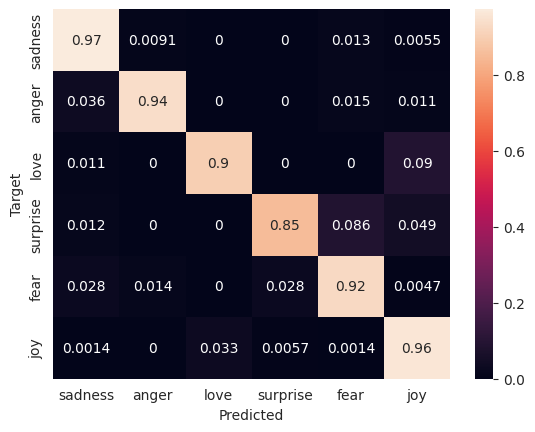

In [44]:
def plot_cm(cm):
    classes = list(target_map.keys())
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

cm = confusion_matrix(ds['validate']['label'], pred_val, normalize='true')
plot_cm(cm)